# Evidence Transfer

In [1]:
import wandb

wandb.init(project='evidence-transfer', config={
    'unet_loss': 'categorical_crossentropy',
    'connecting_unet_layer': 'expanding_block_64_conv2',
    'q_loss': 'binary_crossentropy',
    'q_lambda': 1.5,
    'optimizer': 'adam',
    'batch_size': 3,
    'dataset': 'folds2',
    'max_epochs': 20
})
hparams = wandb.config

wandb: Currently logged in as: vassilis_krikonis (use `wandb login --relogin` to force relogin)
/usr/local/lib/python3.6/dist-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated since IPython 4.0. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [2]:
from models.unet import create_unet
from models.evitram import create_evidence_transfer_model
import tensorflow as tf

unet = create_unet()
unet.load_weights('model-best_0.h5')

q_model = tf.keras.Sequential([
    tf.keras.layers.Conv2D(1, (1, 1), padding='same', activation='sigmoid'),
], name='Q')

evitram = create_evidence_transfer_model(
    unet,
    q_model,
    'expanding_block_64_conv2',
    loss_lambda=hparams['q_lambda']
)

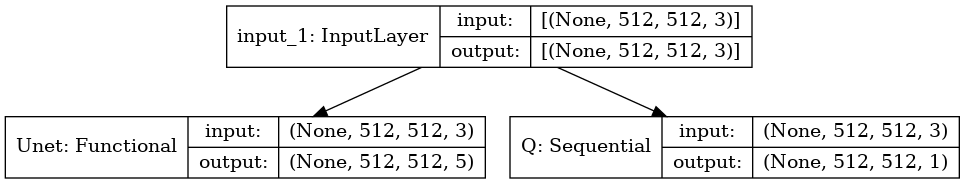

In [3]:
import tensorflow as tf

tf.keras.utils.plot_model(evitram, show_layer_names=True, show_shapes=True)

In [4]:
from metrics import CategoricalMeanIou

evitram.compile(optimizer=hparams['optimizer'], metrics=[
    [CategoricalMeanIou(num_classes=5), 'accuracy'],
    ['accuracy']
])

In [5]:
!mkdir -p /tmp/ds_cache/
from datasets.skyline12 import Skyline12

skyline12 = Skyline12('datasets/skyline12/data/')


def split_outputs(x, y, z):
    return x, (y, z)


FOLDS = 2
train_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='training', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)
val_ds = skyline12 \
    .as_tf_dataset(FOLDS, subset='validation', cache_dir='/tmp/ds_cache/') \
    .map(split_outputs)

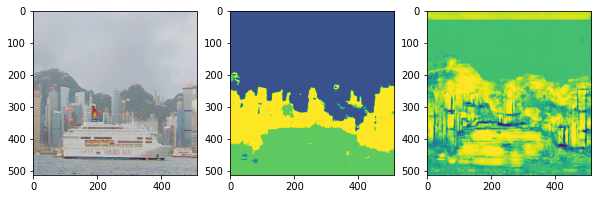

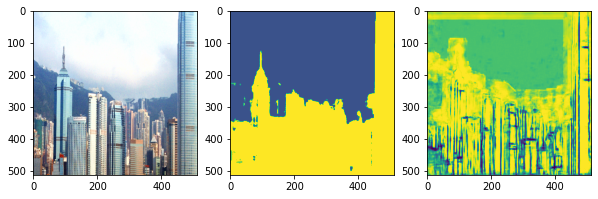

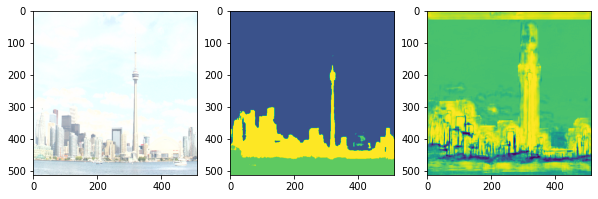

In [6]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [7]:
from tensorflow.keras.callbacks import TensorBoard
from tensorflow.data.experimental import AUTOTUNE
from utils import get_new_logdir
from callbacks import LogEviTRAMImagesWandb
from wandb.keras import WandbCallback

log_dir = get_new_logdir(root_dir='./logs')
batch_size = 3
evitram.fit(
    train_ds.batch(batch_size).prefetch(AUTOTUNE),
    epochs=hparams['max_epochs'],
    validation_data=val_ds.batch(batch_size).prefetch(AUTOTUNE),
    callbacks=[
        TensorBoard(
            log_dir=log_dir,
            histogram_freq=1,
        ),
        LogEviTRAMImagesWandb(next(iter(val_ds.batch(10)))),
        WandbCallback(save_weights_only=True)
    ]
)

Epoch 1/20
80/80 [==============================] - 667s 2s/step - loss: 0.7063 - Unet_categorical_mean_iou: 0.5014 - Unet_accuracy: 0.8903 - Q_accuracy: 0.8187 - val_loss: 0.6555 - val_Unet_categorical_mean_iou: 0.5276 - val_Unet_accuracy: 0.9237 - val_Q_accuracy: 0.9537
Epoch 2/20
80/80 [==============================] - 26s 321ms/step - loss: 0.5092 - Unet_categorical_mean_iou: 0.5342 - Unet_accuracy: 0.9077 - Q_accuracy: 0.9496 - val_loss: 0.6259 - val_Unet_categorical_mean_iou: 0.5171 - val_Unet_accuracy: 0.9191 - val_Q_accuracy: 0.9537
Epoch 3/20
80/80 [==============================] - 26s 322ms/step - loss: 0.4649 - Unet_categorical_mean_iou: 0.5546 - Unet_accuracy: 0.9136 - Q_accuracy: 0.9496 - val_loss: 0.7046 - val_Unet_categorical_mean_iou: 0.5295 - val_Unet_accuracy: 0.9267 - val_Q_accuracy: 0.9537
Epoch 4/20
80/80 [==============================] - 26s 323ms/step - loss: 0.4333 - Unet_categorical_mean_iou: 0.5860 - Unet_accuracy: 0.9219 - Q_accuracy: 0.9496 - val_loss: 0.

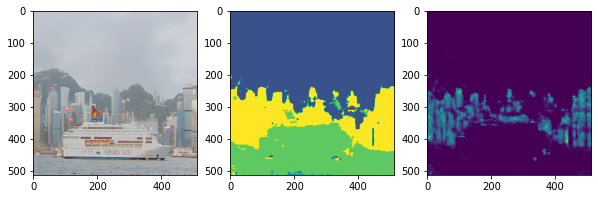

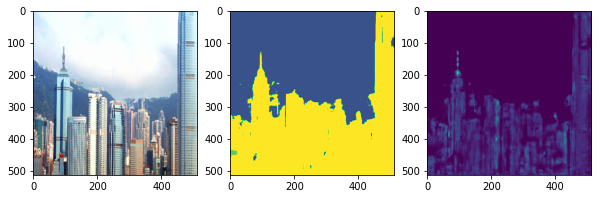

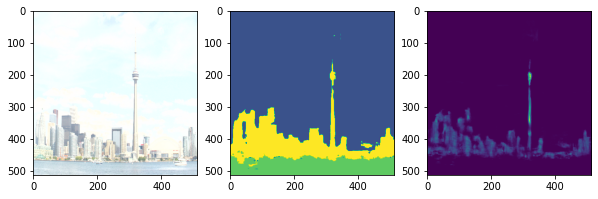

In [8]:
batch_x, _ = next(iter(val_ds.batch(3)))
preds = evitram(batch_x, training=False)

for x, y_pred, z_pred in zip(batch_x, *preds):
    Skyline12.show_sample(x, [y_pred, z_pred], from_tensors=True)

In [9]:
wandb.run.finish()

epoch,19
loss,0.24568
Unet_categorical_mean_iou,0.70019
Unet_accuracy,0.9553
Q_accuracy,0.9521
val_loss,0.65145
val_Unet_categorical_mean_iou,0.51988
val_Unet_accuracy,0.91845
val_Q_accuracy,0.95361
_step,19
_runtime,1611


epoch,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
loss,▇█▅▄▄▃▄▄▂▆▆▄▅▄▃▃▂▁▂▁
Unet_categorical_mean_iou,▁▂▃▅▅▅▅▆▆▁▃▄▄▅▆▇██▇█
Unet_accuracy,▃▄▅▆▆▆▆▇▇▁▄▅▅▆▇▇██▇█
Q_accuracy,▁███████████████████
val_loss,▆▄█▅▂▂▃▆▇▃▁▄▂▄▅▅▆▇▄▅
val_Unet_categorical_mean_iou,█▅██▇▅▆▇▇▁▁▄▃▆▆▆▄▄▄▆
val_Unet_accuracy,▇▆██▇▅▆▇▆▁▂▅▃▅▆▆▄▄▅▆
val_Q_accuracy,▇▇▇▇▇▆█▇▇▇█▇▇█▇▆▃▃▁▂
_step,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
_runtime,▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██
